## PyTorch MLP model

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import ast
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

### Loading training set and blind test set

In [2]:
df_visual = pd.read_csv('./data/ML-CUP21-TR.csv', usecols=[11,12], names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = pd.read_csv('./data/ML-CUP21-TR.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = df_task_tr[7:] # remove first 7 rows of comments
df_visual = df_visual[7:]

df_blind_ts = pd.read_csv('./data/ML-CUP21-TS.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'])
df_blind_ts = df_blind_ts[7:]
df_blind_ts.drop(labels="idx", axis=1, inplace=True)
blind_ts = df_blind_ts.values

### Evaluation metrics

We define the <b>MEE (Mean Euclidean Error)</b> function which is used to evaluate the mean euclidean distance between two points with x and y coordinates.
The function takes in input the true target and the predicted target and yields a floating point number which represents the performance. 

In [3]:
def mee(true_target, predicted_target): #assuming target is 2-dim matrix with x and y as columns
    l = true_target.shape[0]
    res = 0
    
    for p in range(l): #for p-th pattern in l (number of samples)
        x_diff = np.square(true_target[p,0] - predicted_target[p,0]) #difference between the x value of the true and predicted target
        y_diff = np.square(true_target[p,1] - predicted_target[p,1]) #difference between the y values of true and predicted target
        sum_term = x_diff + y_diff
        res = res + np.sqrt(sum_term)
    res = res / l
    
    #return np.average([np.sqrt(np.square(true_target[p,0] - predicted_target[p,0]) + np.square(true_target[p,1] - predicted_target[p,1])) for p in range(l)]) #compact form
    return res

## Regression task
### Preparing the training set

In [4]:
df_task_tr.drop(labels="idx", axis=1, inplace=True)

In [5]:
y = df_task_tr[['x','y']].values
X = df_task_tr.drop(labels=['x','y'], axis=1).values

In [6]:
print(X.shape)
print(y.shape)

(1477, 10)
(1477, 2)


In [7]:
RS_NUMBER = 69

### Splitting the dataset
We split the data set obtaining an internal test set (10% of the total dataset), we will use this internal test at the end to test internally the generalization error.

In [8]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=RS_NUMBER)

print(f"X train shape: {X.shape}")
print(f"X validation shape: {X_test.shape}")
print(f"y train shape: {y.shape}")
print(f"y validation shape: {y_test.shape}")

X train shape: (1329, 10)
X validation shape: (148, 10)
y train shape: (1329, 2)
y validation shape: (148, 2)


### Define the module for the neural network
We define a Module for PyTorch, which takes as input the number of units, activation function (sigmoid, relu or tanh) and the number of hidden layers (can be either one or two). The model architecture is the simplest one of a MLP, one or two linear layers and the activation function.  

In [9]:
class MyModule(nn.Module):
    def __init__(self, num_units, activation_fun, hidden_layers):
        super(MyModule, self).__init__()
        
        if(activation_fun == "sigmoid"):
            activation_fun = nn.Sigmoid()
        elif activation_fun == "relu":
            activation_fun = nn.ReLU()
        elif activation_fun == "tanh":
            activation_fun = nn.Tanh()
            
        if hidden_layers == 2:
            self.linear_stack = nn.Sequential(
                nn.Linear(10, num_units),
                activation_fun,
                nn.Linear(num_units, num_units),
                activation_fun,
                nn.Linear(num_units, 2),
            )
        elif hidden_layers == 1:
            self.linear_stack = nn.Sequential(
                nn.Linear(10, num_units),
                activation_fun,
                nn.Linear(num_units, 2),
            )     
    def forward(self, x):
        X = self.linear_stack(x)
        return X
    
    def predict(self, x):
        X = self.linear_stack(x)
        return X

We define the device where the computation is going to happen (in our case the CPU) and we print a model example with a single hidden layer with 100 hidden units and the sigmoid activation function.  

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

example = MyModule(num_units=100, activation_fun = "sigmoid", hidden_layers = 1).to(device)
print(example)

MyModule(
  (linear_stack): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=2, bias=True)
  )
)


Pytorch is used with skorch which is a wrapper for the framework, the goal of skorch is to make it possible to use PyTorch with sklearn. This will allow us to use the randomized search of sklearn, the NeuralNetRegressor takes the module defined before as input and a callback for the early stopping criteria.

In [11]:
PATIENCE=20
THRESHOLD=0.001

In [12]:
model = NeuralNetRegressor(
    module = MyModule,
    callbacks=[('early_stoppping', EarlyStopping(monitor='valid_loss', patience=PATIENCE, threshold=THRESHOLD))],
)

In [13]:
# define the number of iterations
n_iter_search = 1000
# define number of k-folds
k = 10

In [14]:
X = X.astype(np.float32)
y = y.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)
blind_ts = blind_ts.astype(np.float32)


### Randomized Search

In [15]:
%%script false --no-raise-error

# to find the best set of parameter setting, we can run a randomized search

# define the parameters' values
params = {
    'lr': uniform(0.0001, 0.1),
    'max_epochs': [1000], #upper bound of max number of epochs
    'optimizer': [torch.optim.SGD],
    'optimizer__momentum': [0.9, 0.95], ##optimizer__ indicates that it is a parameter of the optimizer
    'optimizer__weight_decay': uniform(0.0001, 0.1),
    'optimizer__nesterov': [False, True],
    'module__num_units': randint(5, 128), #module__ indicates that it is a parameter of the module
    'module__hidden_layers': [1,2],
    'module__activation_fun': ["sigmoid", "tanh", "relu"],
    'batch_size': randint(1, X.shape[0]),
}

# define the grid search
rand_gs = RandomizedSearchCV(
    model,
    param_distributions=params,
    n_iter=n_iter_search,
    n_jobs=-1,
    scoring=make_scorer(mee), #scoring is based on the highest value so we use the inverse of the MEE loss function
    cv=k,
    random_state=RS_NUMBER,
    verbose=10
)
# run the grid search
rand_gs.fit(X, y)


In [16]:
%%script false --no-raise-error

df_results = pd.DataFrame(data=rand_gs.cv_results_) #trasform into a pandas dataframe
df_results.sort_values(by="rank_test_score", axis=0, ascending=False, inplace=True) #sort rank values in decreasing order 
df_results.dropna(inplace=True) #delete nan values 
df_results = df_results[:50] #keep only top 50 models
pd.DataFrame.to_csv(df_results, "pytorch_results/rand1_search.csv")

In [17]:
df_results = pd.read_csv("pytorch_results/rand1_search.csv")
df_results.head()

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_lr,param_max_epochs,param_module__activation_fun,param_module__hidden_layers,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,350,3.940695,1.971697,0.004922,0.001351,283,0.020099,1000,tanh,2,...,1.196603,1.214653,1.126827,1.166159,1.067476,1.262859,1.030560,1.120913,0.084958,623
1,582,7.513999,2.758514,0.006363,0.003114,682,0.011028,1000,tanh,2,...,1.200430,1.238529,1.170229,1.132420,1.077360,1.240224,1.008873,1.129053,0.079576,622
2,987,3.547924,1.164820,0.005182,0.001618,138,0.005596,1000,tanh,2,...,1.177146,1.231012,1.245564,1.120802,1.056993,1.255631,1.001807,1.136407,0.086634,621
3,173,25.313855,9.177891,0.005296,0.002506,1102,0.002779,1000,tanh,2,...,1.239735,1.216510,1.230578,1.126998,1.068043,1.233900,0.961997,1.138963,0.089424,620
4,751,8.505077,4.147213,0.007505,0.005189,268,0.073478,1000,sigmoid,1,...,1.218813,1.196792,1.224511,1.122006,1.051275,1.250229,1.040875,1.142156,0.076453,619


In [18]:
#get the best params for the grid search (cannot use rand_gs.best_estimator directly since it will yield the worst estimator based on MEE)
best_params = df_results['params'][0]
print(f"Mean error on the {k}-folds (MEE) on best model: {df_results['mean_test_score'][0]}\n")
print(f"Best params: {best_params}")

Mean error on the 10-folds (MEE) on best model: 1.1209130120854107

Best params: {'batch_size': 283, 'lr': 0.020098760986186816, 'max_epochs': 1000, 'module__activation_fun': 'tanh', 'module__hidden_layers': 2, 'module__num_units': 81, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__momentum': 0.9, 'optimizer__nesterov': False, 'optimizer__weight_decay': 0.0034537270776939686}


In [19]:
@dataclass
class GridSearchRanges:
    '''Class of keeping track of the min and max values for the hyperparameters tuning'''
    
    hidden_layers = []
    min_lr = 0
    max_lr = 0
    min_num_units = 0
    max_num_units = 0
    min_weight_decay = 0
    max_weight_decay = 0
    min_bs = 0
    max_bs = 0
    
    def set_ranges(self):

        self.hidden_layers = np.unique(df_results['param_module__hidden_layers'])
        self.hidden_layers = self.hidden_layers.ravel() #convert to array
        print(f"hidden layers: {self.hidden_layers}")

        self.min_lr = np.min(df_results['param_lr'])
        self.max_lr = np.max(df_results['param_lr'])
        print(f"learning rate: [{self.min_lr}, {self.max_lr}]")
        
        self.min_num_units = np.min(df_results['param_module__num_units'])
        self.max_num_units = np.max(df_results['param_module__num_units'])
        print(f"num units: [{self.min_num_units}, {self.max_num_units}]")

        self.min_weight_decay = np.min(df_results['param_optimizer__weight_decay'])
        self.max_weight_decay = np.max(df_results['param_optimizer__weight_decay'])
        print(f"weight decay: [{self.min_weight_decay}, {self.max_weight_decay}]")

        self.min_bs = np.min(df_results['param_batch_size'])
        self.max_bs = np.max(df_results['param_batch_size'])
        print(f"batch size: [{self.min_bs}, {self.max_bs}]")
    
    

In [20]:
gs = GridSearchRanges()
gs.set_ranges()

hidden layers: [1 2]
learning rate: [0.0008988870725362, 0.0883889696278408]
num units: [10, 125]
weight decay: [0.0001164007835073, 0.0477990997654625]
batch size: [85, 1306]


### Second Randomized Search using min e max values

In [21]:
%%script false --no-raise-error

# to find the best set of parameter setting, we can run a randomized search

# define the parameters' values
params = {
    'lr': uniform(gs.min_lr, gs.max_lr),
    'max_epochs': [1000], #upper bound of max number of epochs
    'optimizer': [torch.optim.SGD],
    'optimizer__momentum': [0.9, 0.95], ##optimizer__ indicates that it is a parameter of the optimizer
    'optimizer__weight_decay': uniform(gs.min_weight_decay, gs.max_weight_decay),
    'optimizer__nesterov': [False, True],
    'module__num_units': randint(gs.min_num_units, gs.max_num_units), #module__ indicates that it is a parameter of the module
    'module__hidden_layers': [1,2],
    'module__activation_fun': ["sigmoid", "tanh", "relu"],
    'batch_size': randint(gs.min_bs, gs.max_bs),
}

# define the grid search
rand_gs = RandomizedSearchCV(
    model,
    param_distributions=params,
    n_iter=n_iter_search,
    n_jobs=-1,
    scoring=make_scorer(mee), #scoring is based on the highest value so we use the inverse of the MEE loss function
    cv=k,
    random_state=RS_NUMBER,
    verbose=10
)
# run the grid search
rand_gs.fit(X, y)


In [22]:
%%script false --no-raise-error

df_results = pd.DataFrame(data=rand_gs.cv_results_) #trasform into a pandas dataframe
df_results.sort_values(by="rank_test_score", axis=0, ascending=False, inplace=True) #sort rank values in decreasing order 
df_results.dropna(inplace=True) #delete nan values 
df_results = df_results[:50] #keep only top 50 models
pd.DataFrame.to_csv(df_results, "pytorch_results/rand2_search.csv")

In [81]:
df_results = pd.read_csv("pytorch_results/rand2_search.csv")
df_results.head()

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_lr,param_max_epochs,param_module__activation_fun,param_module__hidden_layers,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,811,16.247680,8.818189,0.004978,0.002359,969,0.011836,1000,tanh,2,...,1.187157,1.211153,1.168652,1.164256,1.052177,1.178131,0.969151,1.111200,0.081319,652
1,177,9.395187,7.242656,0.005083,0.003180,193,0.008206,1000,tanh,2,...,1.181680,1.205948,1.195087,1.096616,1.084006,1.160502,1.024572,1.121309,0.059492,651
2,737,11.662489,8.543175,0.004235,0.002460,352,0.065757,1000,sigmoid,1,...,1.210168,1.192323,1.219596,1.120842,1.061388,1.236586,1.009175,1.130767,0.081693,650
3,571,7.907078,3.242385,0.006320,0.004683,766,0.010558,1000,tanh,2,...,1.204211,1.172090,1.216988,1.112508,1.052585,1.230857,1.106575,1.132414,0.070212,649
4,61,8.987892,3.761606,0.003532,0.001498,552,0.047638,1000,sigmoid,1,...,1.261703,1.208819,1.195609,1.137071,1.028040,1.236204,1.027552,1.133934,0.086132,648


In [82]:
#get the best params for the grid search (cannot use rand_gs.best_estimator directly since it will yield the worst estimator based on MEE)
best_params = df_results['params'][0]
print(f"Mean error on the {k}-folds (MEE) on best model: {df_results['mean_test_score'][0]}\n")
print(f"Best params: {best_params}")

Mean error on the 10-folds (MEE) on best model: 1.1112004747280908

Best params: {'batch_size': 969, 'lr': 0.01183645465779384, 'max_epochs': 1000, 'module__activation_fun': 'tanh', 'module__hidden_layers': 2, 'module__num_units': 98, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__momentum': 0.9, 'optimizer__nesterov': False, 'optimizer__weight_decay': 0.005431615520537502}


In [83]:
best_models = list() #list of the top ten models of the final randomized search

for i in range(10):
    best_params_i = df_results['params'][i]
    first_part = str(best_params_i.split("'optimizer': <class 'torch.optim.sgd.SGD'>, ", 1)[0]) #manually remove the optimizer parameter
    second_part = str(best_params_i.split("'optimizer': <class 'torch.optim.sgd.SGD'>, ", 1)[1])
    best_params_i = first_part+second_part
    
    
    best_params_i = ast.literal_eval(best_params_i)
    HIDDEN_LAYERS = best_params_i['module__hidden_layers']
    NUM_UNITS = best_params_i['module__num_units']
    ACTIVATION_FUN = best_params_i['module__activation_fun']

    OPTIMIZER = 'SGD'
    LR = best_params_i['lr']
    WEIGHT_DECAY = best_params_i['optimizer__weight_decay']

    BATCH = best_params_i['batch_size']
    MAX_EPOCHS = best_params_i['max_epochs']
    NESTEROV = best_params_i['optimizer__nesterov']

    MOMENTUM = best_params_i['optimizer__momentum']
 

    
    module_i = MyModule(NUM_UNITS, ACTIVATION_FUN, HIDDEN_LAYERS)
    model_i = NeuralNetRegressor(
        module = module_i,
        criterion=nn.MSELoss,
        max_epochs=MAX_EPOCHS,
        lr=LR,
        batch_size=BATCH,
        optimizer=torch.optim.SGD,
        optimizer__momentum=MOMENTUM,
        callbacks=[('early_stoppping', EarlyStopping(monitor='valid_loss', patience=PATIENCE, threshold=THRESHOLD))],
    )
    best_models.append(model_i)

In [84]:
#optimizer interferes with evaluation of the string into a dict

first_part = str(best_params.split("'optimizer': <class 'torch.optim.sgd.SGD'>, ", 1)[0]) #manually remove the optimizer parameter
second_part = str(best_params.split("'optimizer': <class 'torch.optim.sgd.SGD'>, ", 1)[1])

best_params = first_part+second_part
best_params = ast.literal_eval(best_params)

### Retrain and evaluation of the best model

In [85]:
HIDDEN_LAYERS = best_params['module__hidden_layers']
NUM_UNITS = best_params['module__num_units']
ACTIVATION_FUN = best_params['module__activation_fun']

OPTIMIZER = 'SGD'
LR = best_params['lr']
WEIGHT_DECAY = best_params['optimizer__weight_decay']

BATCH = best_params['batch_size']
MAX_EPOCHS = best_params['max_epochs']
NESTEROV = best_params['optimizer__nesterov']

MOMENTUM = best_params['optimizer__momentum']
 

In [86]:
def plot_learning_curves(train_scores, test_scores, epochs, y_label):
    plt.figure(figsize=(10,8))
    plt.plot(range(0,epochs), train_scores, label = "Training error", linestyle='dashed')
    plt.plot(range(0,epochs), test_scores, label = "Test error")
    plt.legend()
    plt.ylabel(y_label)
    plt.xlabel('Epoch');

In [87]:
#redefine the model with the best params
module = MyModule(NUM_UNITS, ACTIVATION_FUN, HIDDEN_LAYERS)
eval_module = MyModule(NUM_UNITS, ACTIVATION_FUN, HIDDEN_LAYERS)
print(module)


MyModule(
  (linear_stack): Sequential(
    (0): Linear(in_features=10, out_features=98, bias=True)
    (1): Tanh()
    (2): Linear(in_features=98, out_features=98, bias=True)
    (3): Tanh()
    (4): Linear(in_features=98, out_features=2, bias=True)
  )
)


In [88]:
#trains the model with one iteration (epoch) and computes in output a list of train and test scores using MEE
def fit_and_score(epochs, eval_model, X_train, y_train, X_test, y_test):
    train_scores = []
    test_scores = []
    train_loss = []
    test_loss = []
    eval_model.initialize()
    for i in range(epochs):
        eval_model = eval_model.fit_loop(X_train,y_train,1) #single epoch of the model
        y_train_predicted = eval_model.predict(X_train)
        y_test_predicted = eval_model.predict(X_test)
        #results on train set
        train_scores.append(mean_squared_error(y_train, y_train_predicted))
        test_scores.append(mean_squared_error(y_test, y_test_predicted))
        #result on test set
        train_loss.append(mee(y_train, y_train_predicted))
        test_loss.append(mee(y_test, y_test_predicted))
    return train_scores, test_scores, train_loss, test_loss


In [89]:
model = NeuralNetRegressor(
    module = module,
    criterion=nn.MSELoss,
    max_epochs=MAX_EPOCHS,
    lr=LR,
    batch_size=BATCH,
    optimizer=torch.optim.SGD,
    optimizer__momentum=MOMENTUM,
    callbacks=[('early_stoppping', EarlyStopping(monitor='valid_loss', patience=PATIENCE, threshold=THRESHOLD))],
)

In [90]:
model.fit(X, y)
y_predicted = model.predict(X)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      234.8083      200.3089  0.0210
      2      182.6786       42.8888  0.0222
      3       42.3608       86.7439  0.0571
      4       87.9117       10.1135  0.0254
      5       14.2446       43.1398  0.0545
      6       37.0682        9.3051  0.0198
      7       10.9580       23.0841  0.0201
      8       21.9210        7.9257  0.0272
      9        8.2532       13.1291  0.0209
     10       11.6548        2.4921  0.0593
     11        3.0754        7.6643  0.0249
     12        7.4168        2.2992  0.0660
     13        2.6692        5.2289  0.0233
     14        5.3843        2.0523  0.0209
     15        2.4444        2.8877  0.0210
     16        3.2297        2.4474  0.0187
     17        2.6843        1.4602  0.0683
     18        1.8972        2.5086  0.0186
     19        2.6737        1.7452  0.0661
     20        1.9446        1.6444  0.0252
     21        1.9500        1.7

In [91]:
print(f"MEE: {mee(y, y_predicted)}")

MEE: 0.931827266953894


In [92]:
y_predicted_test = model.predict(X_test)
print(f"MEE: {mee(y_test, y_predicted_test)}")

MEE: 1.0915023296366673


In [93]:
y_predicted_blind = model.predict(blind_ts)

In [95]:
history = model.history
EPOCHS = len(history)

In [96]:
eval_model = NeuralNetRegressor(
    module = eval_module,
    criterion=nn.MSELoss,
    max_epochs=EPOCHS,
    lr=LR,
    batch_size=BATCH,
    optimizer=torch.optim.SGD,
    optimizer__momentum=MOMENTUM,
)

In [97]:
train_scores, test_scores, train_loss, test_loss = fit_and_score(EPOCHS, eval_model, X, y, X_test, y_test)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      232.0912      181.5096  0.0200
      2      163.3639       17.0799  0.0263
      3       23.4003       63.0041  0.0618
      4       61.9609       15.8648  0.0178
      5       16.6900       27.5478  0.0664
      6       23.1176        8.6311  0.0173
      7       10.5305       14.8878  0.0250
      8       14.4669       11.6394  0.0195
      9       12.4471        5.8125  0.0198
     10        7.0721        3.7871  0.0161
     11        4.7673        5.1867  0.0179
     12        5.7621        2.1118  0.0214
     13        2.6475        2.6451  0.0182
     14        3.0170        3.0168  0.0186
     15        3.0509        1.8668  0.0184
     16        2.1372        1.8051  0.0183
     17        2.0997        1.8085  0.0271
     18        2.0312        1.9080  0.0273
     19        2.1102        1.4741  0.0161
     20        1.7793        1.4373  0.0218
     21        1.6996        1.5

## Loss Curves

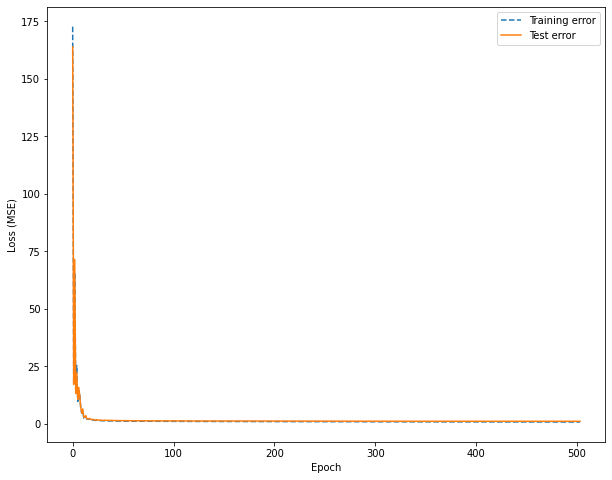

In [98]:
plot_learning_curves(train_scores, test_scores, EPOCHS, "Loss (MSE)")

## Learning Curves

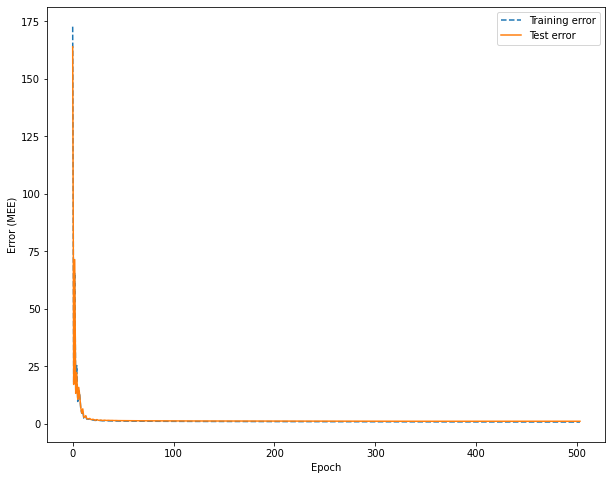

In [99]:
plot_learning_curves(train_scores, test_scores, EPOCHS, "Error (MEE)")

In [70]:
def plot_coordinates(y_predicted, true_y = None):
    y_predicted = pd.DataFrame(data=y_predicted, columns=["x", "y"])
    if not None:
        true_y = pd.DataFrame(data=true_y, columns=["x", "y"])
        plt.scatter(true_y['x'], true_y['y'], c='r', marker='*')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4')


In [80]:
### Predicted points on internal test set

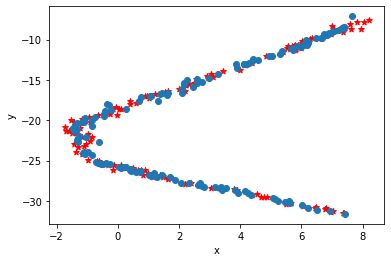

In [71]:
plot_coordinates(y_predicted_test, y_test)

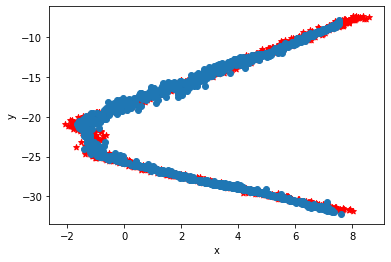

In [72]:
plot_coordinates(y_predicted, y)

### Predicted points on blind test set

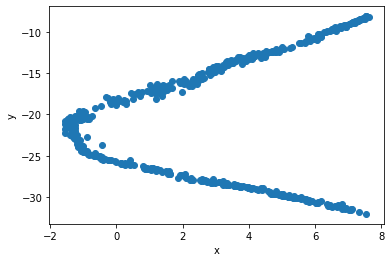

In [73]:
plot_coordinates(y_predicted_blind)

## Ensemble 

Then we try the voting method using the 10 best models from the randomized search. 

In [74]:
#fit every model
for model in best_models:
    model.fit(X,y)


    213        1.0971        0.9284  0.0663
    214        1.0965        0.9281  0.0260
    215        1.0958        0.9277  0.0624
    216        1.0952        0.9273  0.0209
    217        1.0945        0.9270  0.0195
    218        1.0939        0.9266  0.0740
    219        1.0932        0.9263  0.0187
    220        1.0926        0.9260  0.0508
    221        1.0919        0.9256  0.0199
    222        1.0913        0.9253  0.0189
    223        1.0907        0.9250  0.0616
    224        1.0901        0.9246  0.0190
    225        1.0894        0.9243  0.0182
    226        1.0888        0.9240  0.0681
    227        1.0882        0.9237  0.0191
    228        1.0876        0.9234  0.0614
    229        1.0870        0.9231  0.0171
    230        1.0864        0.9228  0.0148
    231        1.0858        0.9225  0.0678
    232        1.0852        0.9222  0.0166
    233        1.0846        0.9219  0.0164
    234        1.0840        0.9216  0.0726
    235        1.0834        0.9

In [75]:
y_predictions_internal_test = list()
y_predictions_blind_test = list()

#predictions on every model is averaged
for model in best_models:
    y_pred_train = model.predict(X_test)
    y_predictions_internal_test.append(y_pred_train)
    y_pred = model.predict(blind_ts)
    y_predictions_blind_test.append(y_pred)

In [76]:
y_pred_voting_ens_train_test = np.average(y_pred_train, axis=0)
y_pred_voting_ens_internal_test = np.average(y_predictions_internal_test, axis=0)
y_pred_voting_ens_blind_test = np.average(y_predictions_blind_test, axis=0)

print(f"MEE: {mee(y_test, y_pred_voting_ens_internal_test)}")

MEE: 1.0771853019156166


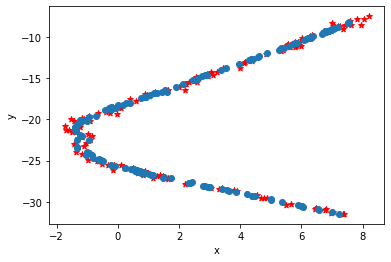

In [77]:
y_predicted = pd.DataFrame(data=y_pred_voting_ens_internal_test, columns=["x", "y"])
true_y = pd.DataFrame(data=y_test, columns=["x", "y"])
plt.scatter(true_y['x'], true_y['y'], c='r', marker='*')
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4');

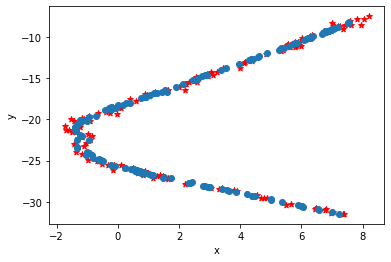

In [78]:
y_predicted = pd.DataFrame(data=y_pred_voting_ens_internal_test, columns=["x", "y"])
true_y = pd.DataFrame(data=y_test, columns=["x", "y"])
plt.scatter(true_y['x'], true_y['y'], c='r', marker='*')
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4');

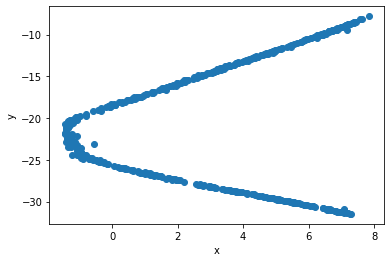

In [79]:
y_predicted = pd.DataFrame(data=y_pred_voting_ens_blind_test, columns=["x", "y"])
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4');

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>